En VSCode! Si no funciona por ejemplo dice "requires pip & notebook package" ir a extensiones --> buscar Python Enviroment Manager --> Instalar --> al final de la barra lateral aparecerá el icono de python, buscan geofluidos2 y seleccionan el pulgar arriba (set as active workspace interpreter).

# **Redes Neuronales Convolucionales (CNN)**
## **<font color='lightblue'>Repaso corto de Redes Neuronales Convolucionales.</font>**

### **<font color='lightblue'>Perceptrón vs Filtro Convolucional?</font>**

 El perceptrón recibe múltiples señales de entrada (x). Si la suma de las señales supera un umbral determinado, se produce una señal o, por el contrario, no se emite ningún resultado(f). Por lo que un perceptrón se puede relacionar como:

$$
out = f(\sum^n w_n * x_n + b)
$$

Notemos que el perceptrón para dar un valor de salida, requiere información de todos los valores que componen la entrada. En cambio un filtro convolucional, que es lo que distingue, procesa información de forma local, es decir, posicionado en un punto central captura señales del entorno de dicho punto.

El kernel, como ya vimos en el caso 1D, es un vector de pesos (o una función de densidad) que recorre una función objetivo, y en ese caso tratabamos de ajustar los pesos de ese kernel, para realizar una estimación de la función objetivo a partir del entorno punto a punto. En este caso, usaremos kernels 2D que es la misma idea pero sobre matrices. Recordemos también que la forma de operar era con un producto escalar elemento a elemento, y en este caso también lo es. También como el caso de un perceptrón las salidas de los filtros convolucionales pueden tener una función de activación, y entonces dicha salida se puede escribir como: 

$$
out = f(\sum^n w_n * x_n + b)
$$
con n = k * l dimensiones del kernel de (k,l).


Vaya novedad...

A su vez se dice que el filtro convolucional además de extraer información local, es un invariante traslacional, ya que el mismo filtro recorre y aplica a toda la matriz (en 2D, también existen las convoluciones 3D). Y otra definición a tener en cuenta es la de capa convolucional, que se la denomina así al conjunto de filtros convolucionales que operan sobre una misma entrada. 

![alternative text](./images_CONV/convolucion.png)


### **<font color='lightblue'>¿Que es una Red Neuronal Convolucional?</font>**
De forma similar que las Redes Neuronales Artificiales, la sucesión de capas convolucionales conforman la Red Neuronal Convolucional. En la cual los filtros de las capas convolucionales iniciales aprenden patrones simples, y en profundidad patrones más complejos. Y de ahí surge el concepto de Deep Learning, que no solo aplica a Redes Convolucionales, si no que a Redes Neuronales Artificiales también.


**<font color='lightblue'>Otra capa importante: Maxpooling<font>**

Es maxpooling es un kernel que recorre la entrada al igual que el filtro convolucional, pero en este caso su objetivo es retener el valor máximo de la salida del filtro convolucional. Esta capa tiene dos grandes fortalezas:
- Es conservador de la Varianza.
- Es un reductor de la Dimensionalidad. 

![alternative text](./images_CONV/maxpooling.png)


Les dejo una [página](https://poloclub.github.io/cnn-explainer/) para que la exploren luego, pero es un buen ejercicio verlo en acción y como operan las convoluciones internamente.

## Importamos las librerias y funciones que necesitaremos.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import set_dataset as ds
import verificacion as ver
import plots

### Fijamos la semilla

Esto es importante para lograr la reproducibilidad de los experimentos que realicemos, y que no sea un factor de incertidumbre.

In [3]:
def define_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

define_seed(seed=1029)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Elegimos las variables de Entrada (Input) y Objetivo (Target)

In [4]:
Input_name =  "sdbz"
Target_name = "rain"
Experimento = Input_name+"_vs_"+ Target_name

## Lectura de los datos

In [5]:
#Porcentaje de reparticion de los conjuntos de Train / Validation / Testing
train_ratio = .8
val_ratio = .1
test_ratio = .1

#Aplicar Data Augmentation
Data_Aug = False

# Lectura de los datos
#Reflectividad de radar simulada
#Tasa de precicpitacion
Data, x_train, y_train, x_val, y_val, x_test, y_test = ds.get_data("./DATA/datos_WRF_nx40.npz",
                                                                   Input_name, Target_name, train_ratio, val_ratio, test_ratio, Data_Aug)
nx, ny = Data["nx"], Data["ny"]

print("Muestras de Train / Valid / Test: ",(Data["len_train"],Data["len_val"],Data["len_test"]))

Training set starts at : 0  and ends at:  1217
Validation set starts at : 1218  and ends at:  1369
Testing set starts at:  1370  and ends at:  1522
Muestras de Train / Valid / Test:  (1218, 152, 153)


## Analicemos los datos

14.927425176833497
6.091172029286211


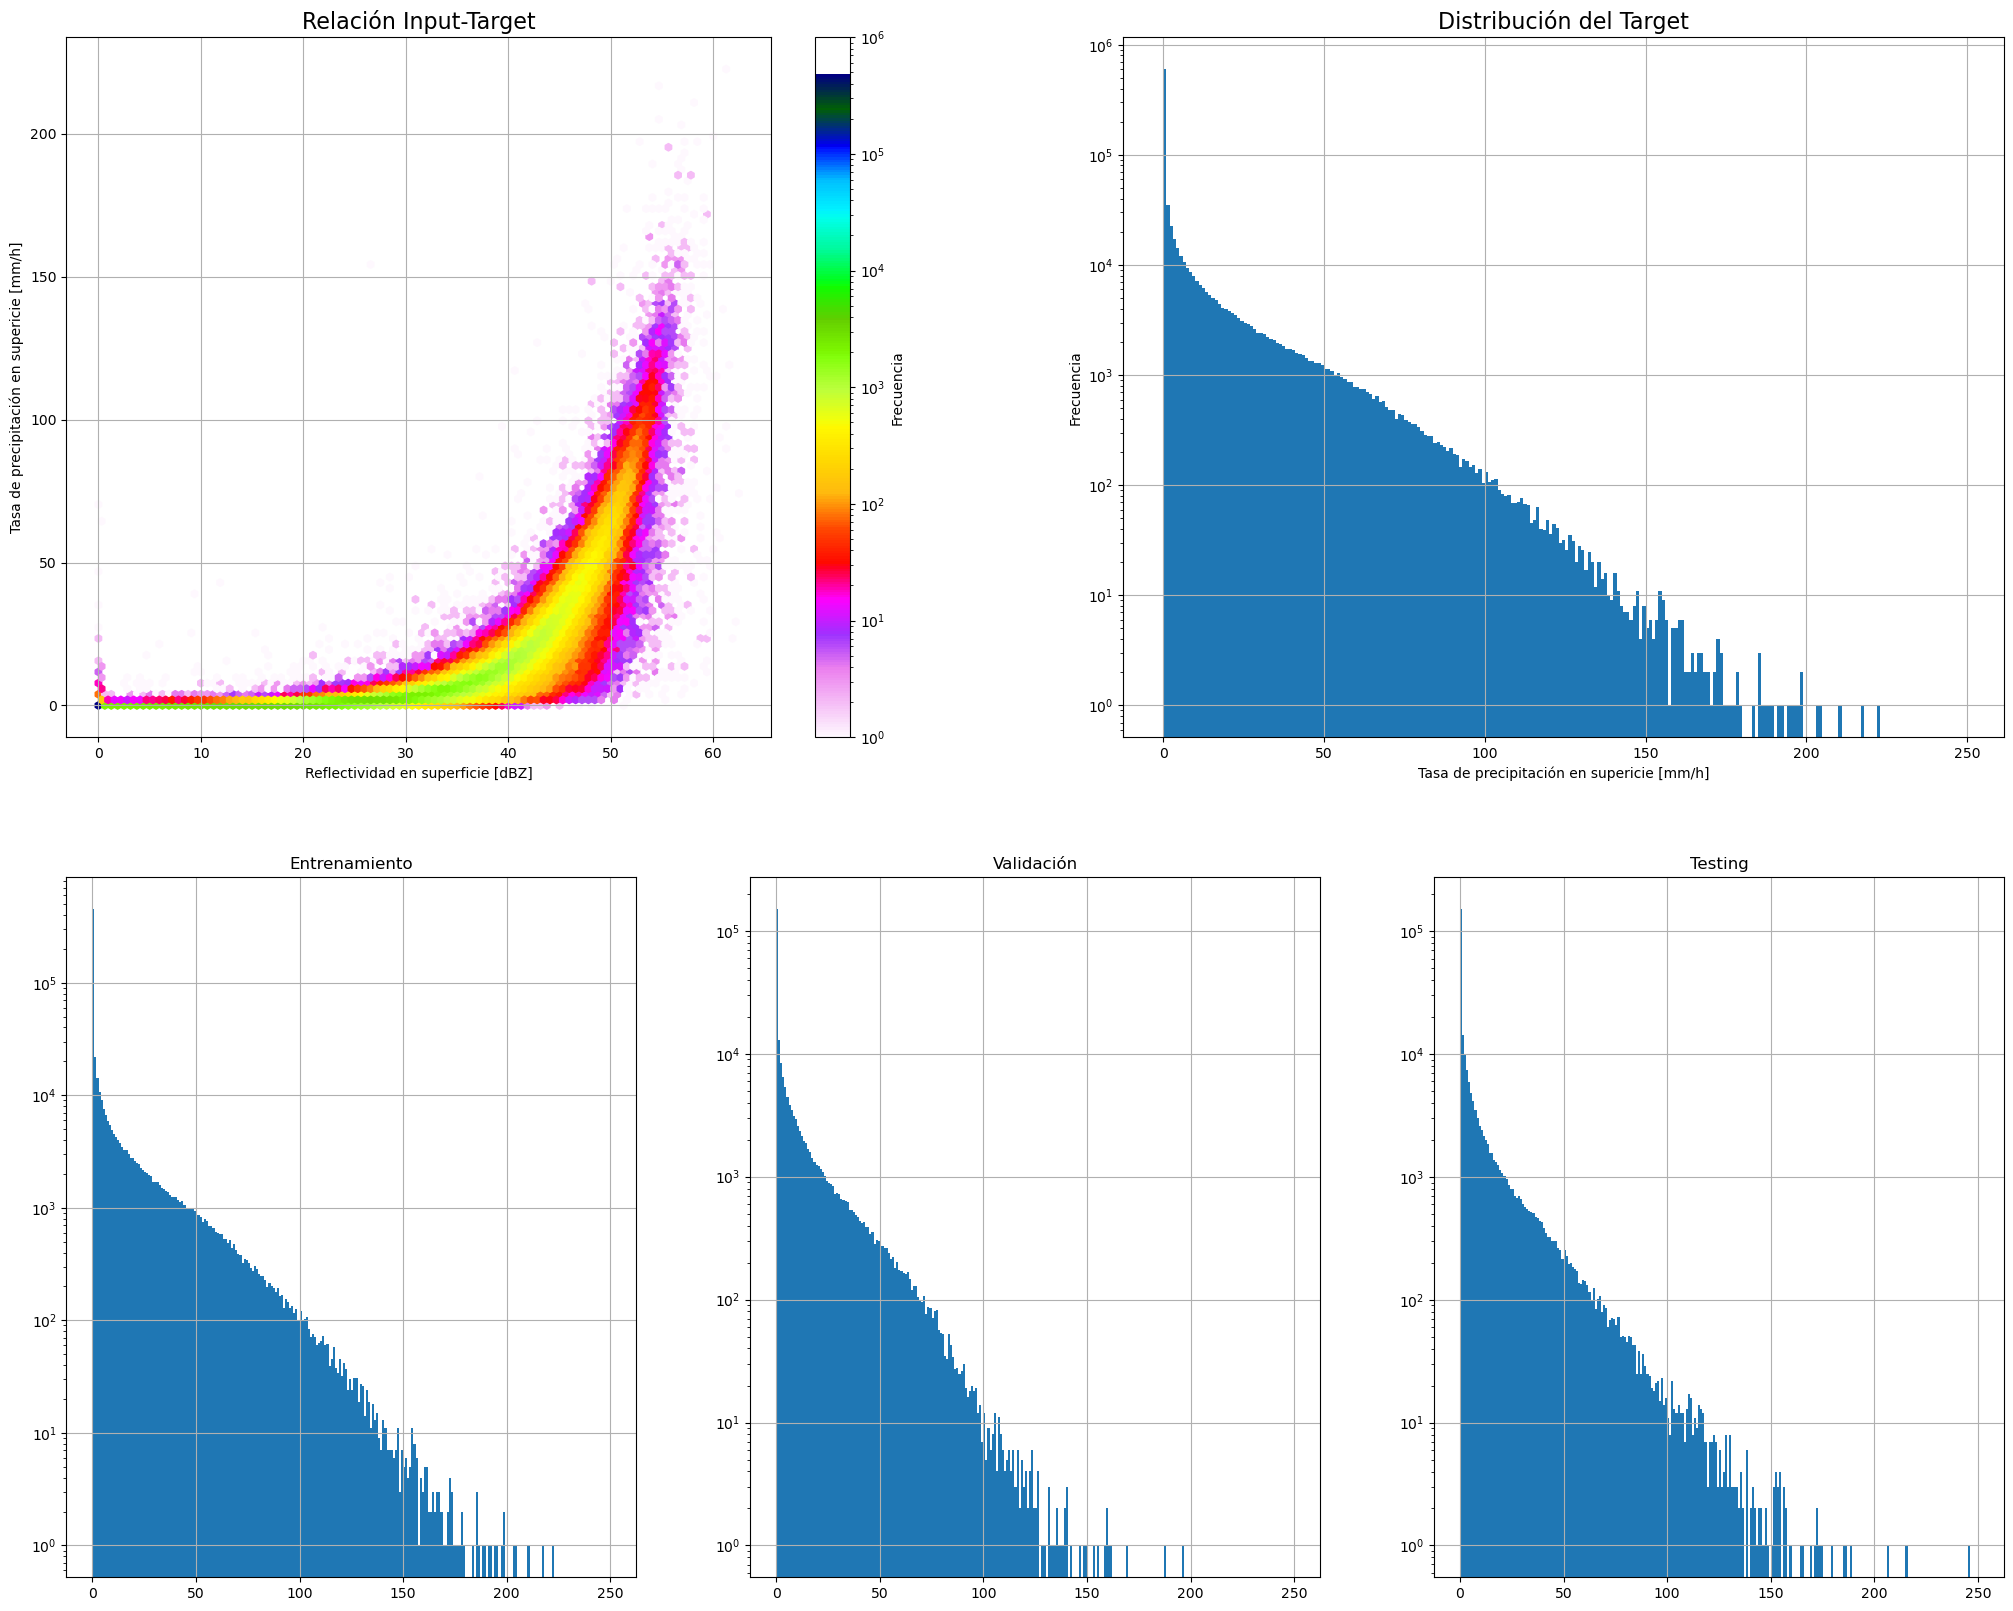

In [6]:
fig1 = plt.figure(figsize=(25,20))

plt.subplot(2,2,1)
plt.title("Relación Input-Target",fontsize=16)
plt.hexbin(np.append(x_train,x_val,axis=2),np.append(y_train,y_val,axis=2),cmap = 'gist_ncar_r',bins='log',gridsize=100)
plt.xlabel("Reflectividad en superficie [dBZ]") ; plt.ylabel("Tasa de precipitación en supericie [mm/h]")
print(np.append(y_train,y_val,axis=2).std())
print(np.append(y_train,y_val,axis=2).mean())

cbar = plt.colorbar(orientation="vertical")
cbar.set_label("Frecuencia")
cbar.set_ticks([1,10,100,1000,10000,100000,1000000])
cbar.set_ticklabels([r'10$^0$',r'10$^1$',r'10$^2$',r'10$^3$',r'10$^4$',r'10$^5$',r'10$^6$'])

plt.grid()

plt.subplot(2,2,2)
plt.title("Distribución del Target",fontsize=16)
plt.hist(np.append(y_train,y_val,axis=2).flatten(),bins=range(250))
plt.yscale("log")
plt.xlabel("Tasa de precipitación en supericie [mm/h]") ; plt.ylabel("Frecuencia")
plt.grid()

plt.subplot(2,3,4)
plt.title("Entrenamiento")
plt.hist(y_train.flatten(), bins=range(251))
plt.yscale("log")
plt.grid()

plt.subplot(2,3,5)
plt.title("Validación")
plt.hist(y_val.flatten(), bins=range(251))
plt.yscale("log")
plt.grid()

plt.subplot(2,3,6)
plt.title("Testing")
plt.hist(y_test.flatten(), bins=range(251))
plt.yscale("log")
plt.grid()

el objetivo es que la red tome de input la reflectividad y genere un campo de precipitacion

## Hiperparametros

Los hiperparametros son definidos, generalmente de forma manual, y determinan el entrenamiento de los modelos. En cambio un parametro, es estimado en el entrenamiento, por ejemplos pesos y bias.

Los hiperparametros con que más nos toparemos son los siguentes:

- **_Batch size_**: Es el tamaño de las muestras en las que se divide el dataset (no confundir con los datasets de entrenamiento/validación y testing), que se empaquetan en un tensor durante las iteraciones de entrenamiento. EL BATCH SIZE SIEMPRE ES MENOR O IGUAL AL TAMAÑO DE LOS DATOS DEL CONJUNTO DE ENTRENAMIENTO

- **_Épocas_**: Controla el número de pasadas completas por el conjunto de datos de entrenamiento. LA CANTIDAD DE EPOCAS ES MANUAL TEORICAMENTE ES INFINITO

- **_Tasa de aprendizaje / Learning Rate_**: Es el factor de escala (también llamado paso de movimiento) que proporciona la cantidad de ajuste que optimiza los parámetros (pesos y bias) a partir de considerar el gradiente de la función de costo.

- **_Función de costo_**: En cada paso de entrenamiento (es decir, para cada batch en cada eṕoca) se comparan la salida del modelo contra la verdad (Target), y esa comparación se cuantifica en una métrica que propongamos.


In [7]:
#Una forma de identificar la configuración que utilizamos
Modelo = "Convolucion"
Numero_exp = 0

#Hiperparametros
batch_size= 100
max_epochs = 60
learning_rate = 1e-3 

#El learning rate decay seria algo que ayuda a converger. A partir de una cierta epoca el learning rate
#decay va decayendo a un ritmo de 0.1 
lr_decay = False
if lr_decay:
    milestones = [45] ; gamma=0.1

#Definimos la función de costo que queremos minimizar, y también el método de calculo sobre el batch.
MSE_Loss = torch.nn.MSELoss(reduction='mean')

tiene sentido que el learning rate tenga un orden de 10**-3 debido a tambien como es la funcion de costo. Generlamente esta estaandrizada, y tambien pensa en como seran los pesos 

In [8]:
Directorio_out = "./salidas/"+Modelo+"_"+Experimento+"_"+str(Numero_exp)+"/"

if not os.path.exists(Directorio_out):
    # Creo un nuevo directorio si no existe (para guardar las imagenes y datos)
    os.makedirs(Directorio_out)
    print("El nuevo directorio asociado a "+ Experimento +" "+str(Numero_exp)+" ha sido creado!")

### Definimos el modelo a utilizar

Utilizaremos el **_método forward_** para la construcción de nuestra arquitectura de red neuronal. El método forward (hacia adelante) como indica su nombre se basa en pasar nuestro input por los atributos que definimos en el **_class_**, en particular en el **_método init_** que para esto sirve. Es decir, vamos a hacer pasar el input por las sucesivas capas que componen la red neuronal hasta que llegar el output, la capa final.

Existe otra forma de construir la red neuronal, y es bajo la función **nn.Sequential**, que funciona igual que el método forward pero en este caso solo definimos las capas de la red neuronal, en el orden que queremos. Un ejemplo:

model = nn.Sequential(
  \
          nn.Linear(in_features = 16, out_features = 8),
  \
          nn.ReLU(),
  \
          nn.Linear(in_features = 8, out_features = 16),
  \
          nn.SiLU()
  \
        )

Usar el nn.Sequential es más sencillo e implica menos código, pero el beneficio del método forward es que permite construir de una forma más manipulable arquitecturas más complejas. Por ejemplo, si se requiere trabajar con varios inputs "independientes" entre si, y se quiere que la red neuronal en las primeras capas procese esos inputs de forma separada. Más especificamente con Redes Neuronales Convolucionales, si se requiere trabajar con **bloques** (que son un combinación de capas convolucionales para extraer ciertas características o generar procesamientos especificos), usar este método es más amigable.

Tips para optimizar lineas de código (válida para nn.Sequential también), se pueden componer las con capas de las red neuronal entre sí:

def forward(self, x):
\
&emsp; &emsp; self.activation_2(self.Linear_2(x))

Lo recomendable para que sea entendible es una capa de activación compuesta con la correspondiente capa neuronal.

In [9]:
class Convolucional(nn.Module):

    def __init__(self, nx, ny,filters): #Definimos los atributos de la clase
        super().__init__()

        #Nx serian tus entradas latitud (en nuestro ejemplo)
        #Ny tambien tu otra entrada lo que seria longitud
        self.nx, self.ny = nx, ny #Si se usan linears, es bueno guardalo...

        #in_chanels: seria tu matriz de entrada que es 1
        #out chanel: tu matriz de salida que es 16 salidas, una por cada kernel
        #kernel_size: que tamaño tiene el kernel 5x5
        #stride: pasos de iteracion en este caso se mueve un punto de reticula
        #padding: agrega 2 columna y dos filas
        #paddin_mode : reflect es que el borde se pone, en este caso uno similar al punto de reticula, podria ser 0
        #bias : True es buena idea activarlo
        self.conv_1 = nn.Conv2d(in_channels = filters[0],out_channels = filters[1], kernel_size=5 ,stride = 1, padding= 2, bias=True, padding_mode='reflect')
        self.conv_2 = nn.Conv2d(in_channels = filters[1], out_channels = filters[2], kernel_size=5 ,stride = 1, padding= 2, bias=True, padding_mode='reflect')
        
        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.SiLU()
        
        #self.dropout_2d = nn.Dropout2d(p=0.2, inplace=False)
        
        #self.maxpool = nn.MaxPool2d(2)
        
        #self.transpconv_1 = nn.ConvTranspose2d(in_channels = filters[1],out_channels = filters[2], kernel_size=5 ,stride = 2, padding= 2, output_padding=1, bias=True)
        
        #self.Conv_BN_1 = torch.nn.BatchNorm2d(filters[1],affine=True) #Igual cantidad que la cantidad de filtros de salida
        

    def forward(self, x): #Ejecutamos con este método los atributos que definimos
        x = torch.unsqueeze(x,1) # x - Shape 4D: (batch size, filtros, nx, ny)
        
        x = self.conv_1(x)
        x = self.activation_1(x)

        x = self.conv_2(x)
        x = self.activation_2(x)

        return torch.squeeze(x)
    
#una imagen de entrada en el primer filtro

filters = [1,16,1]

#Aca instancia la clase como modelo
model = Convolucional(nx,ny,filters)
model.to(device) #Cargamos en memoria, de haber disponible GPU se computa por ahí
print("nx = {nx}","ny = {ny}")

nx = {nx} ny = {ny}



**<font color='green'>Preguntas</font>**

- **<font color='green'>En función de la arquitectura de red neuronal a utilizar. Cuente y discuta cuentos parámetros entrenables posee la red neuronal en cuestión y compare con la cantidad de datos que se poseen.</font>**

# Configuración de la Red Neuronal

## Descenso del gradiente y actualización de los parametros

El gradiente de una función apunta en la dirección de máximo crecimiento de esta, y bajo esta premisa se utiliza el método de optimización conocido como **descenso del gradiente**, que como insinua su nombre está asociado a la dirección contraria al gradiente de una función objetivo, que este caso es la función de costo que queremos minimizar. La longitud del paso de actualización de los parametros de la red neuronal estaran determinados entonces por los puntos donde la función de costo pasa de decrecer a crecer (es decir mínimos), siguiendo el siguiente proceso iterativo:
$$
  w_n^{t+1} = w_n^{t} - \lambda * \frac{\partial{Loss}}{\partial{w_n^{t}}} \qquad w_n^{t}: Peso \; n-ésimo \; en \; paso \; de \; actualización \; t, \; \lambda: Learning \: Rate
$$ (my_other_label)
Cuando la función de costo satisface ciertas condiciones de regularidad (son del tipo C) el algoritmo converge a un mínimo local, que termina siendo un mínimo global en el caso de funciones estrictamente convexas. Por este motivo, es que es deseable que las funciones de costo que utilicemos sea convexas (-> U ), como por ejemplo el MSE.

## Otras configuraciones: Optimizador e Inicialización de pesos.

Estrictamente lo siguiente que definiremos son hiperparametros también. Ya que son configuraciones que definimos en la etapa de pre-entrenamiento, y son sumamente importantes porque configuran el objetivo y forma de entrenamiento. 

Los pesos se actualizaran siguiendo la idea del algoritmo de descenso del gradiente, donde la función a minimizar es la **_Función de costo (Loss Function)_** que definimos.

A partir del algoritmo de **_Backprogation_** se propagara el costo y se imputará sobre los parámetros (pesos y bias) de la red neuronal.

El **_Optimizador_** es el método de actualización de los pesos en cada época. En particular en este caso, utilizaremos ADAM (ADAptative Moment estimation). Brevemente lo que hace es computar un learning rate para cada paramametro (la parte adaptativa del optimizador) y también guarda el decaimiento promedio de los gradientes anteriores. Esto último en las primeras épocas es donde más se hace notar este efecto, porque los gradientes suelen ser mayores/bruscos adaptandose a los datos.

El "punto de partida" de los parametros a optimizar para la minimización de la Función de costo, está dada por la **_distribución inicial de los pesos_**. La cual es importante considerar debido a que puede colaborar a lograr una rápida convergencia de la red neuronal hacia el mínimo global de la función de costo (de encontrarse) o por el contrario atentar contra esto y requerir un mayor número de eṕocas para lograr la convergencia.

Notas sobre inicialización de pesos: https://eva.fing.edu.uy/pluginfile.php/317369/mod_resource/content/3/c9.pdf

Es una funcion para iniciar los pesos de manera random, la magnitud de los pesos va decayendo al pasar de las capas 

In [11]:
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.constant_(m.bias, 0)

initialize_weights(model) #Definimos los pesos iniciales con los cuales inicia el modelo antes de entrenarlo

#Definimos el optimizador (descenso de gradiente)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

#Definimos el Scheduler para el Learning Rate
if lr_decay:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = gamma, verbose = True)

# Entrenamiento de la Red Neuronal

## DataLoader

In [13]:
#Preparamos los 3 conjuntos que definimos entrenamiento, validación y testing para que ingresen al dataloader

#Input matriz de 40x40x31
#Output matriz de 40x40x31
train_subset = ds.set_up_data(Data=Data, Input = x_train, Target = y_train)
val_subset = ds.set_up_data(Data=Data, Input = x_val,   Target = y_val)
test_subset = ds.set_up_data(Data=Data, Input = x_test,  Target = y_test)

#Definimos los dataloaders
#El dataloader de train tiene definido el batch_size, no asi los de validacion y test.
#Generalmente porque en comparación son mucho más chicos.
dataloader_train = DataLoader(train_subset, batch_size = batch_size, shuffle=True)   
dataloader_val   = DataLoader(val_subset , batch_size=len( val_subset) )
dataloader_test  = DataLoader(test_subset , batch_size=len( test_subset) )

## Entrenando la Red Neuronal


**<font color='red'>Teniendo en cuenta lo anterior y la función de costo definida. Observe como en cada época varia la loss para el conjunto de entrenamiento y el de validación.</font>**

In [14]:
#Listas donde guardamos loss de entrenamiento, y para el de validación la loss y las métricas de evaluación.
RMSE, BIAS, Corr_P, Corr_S = [], [], [], []
loss_train, loss_val = [], []

#Uno recorre varias veces los mismos datos para acercarse al minimo 
#recordemos que 
for epoch in range(max_epochs):
    print('Epoca: '+ str(epoch+1) + ' de ' + str(max_epochs) )
    
    #Entrenamiento del modelo        
    model.train()  #Esto le dice al modelo que se comporte en modo entrenamiento.

    sum_loss = 0.0
    batch_counter = 0

    # Iteramos sobre los minibatches. 
    for inputs, target in dataloader_train :
        #Enviamos los datos a la memoria.
        inputs, target = inputs.to(device), target.to(device)
        #-print( 'Batch ' + str(batch_counter) )

        optimizer.zero_grad()

        outputs = model(inputs)
            
        loss = MSE_Loss(outputs.float(), target.float())
                    
        loss.backward()
        optimizer.step()
                    
        batch_counter += 1
        sum_loss = sum_loss + loss.item()

    if lr_decay:
      scheduler.step()

    #Calculamos la loss media sobre todos los minibatches 
    loss_train.append( sum_loss / batch_counter )

    #Calculamos la funcion de costo para la muestra de validacion.
    input_val , target_val = next( iter( dataloader_val ) )
    input_val , target_val = input_val.detach().to(device) , target_val.detach().to(device) 
    with torch.no_grad():
      output_val = model( input_val )

    loss_val.append( MSE_Loss( output_val , target_val ).item() )

    #Calculamos la funcion de costo para la muestra de testing.
    model.eval()   #Esto le dice al modelo que lo usaremos para evaluarlo (no para entrenamiento)
    input_test , target_test = next( iter( dataloader_test ) )
    input_test , target_test = input_test.detach().to(device) , target_test.detach().to(device) 
    #zzprint( input_test.shape )
    with torch.no_grad():
      output_test = model( input_test )

    #Calculo de la loss de la epoca
    print('Loss Train: ', str(loss_train[epoch]))
    print('Loss Val:   ', str(loss_val[epoch]))

    ###################################
    np_input_test  = ds.denorm( input_test.numpy()  , dataloader_test.dataset.xmin, dataloader_test.dataset.xmax )
    np_target_test = ds.denorm( target_test.numpy() , dataloader_test.dataset.ymin, dataloader_test.dataset.ymax )
    np_output_test = ds.denorm( output_test.detach().numpy() , dataloader_test.dataset.ymin, dataloader_test.dataset.ymax )
    
    np_input_val  = ds.denorm( input_val.numpy()  , dataloader_val.dataset.xmin, dataloader_val.dataset.xmax )
    np_target_val = ds.denorm( target_val.numpy() , dataloader_val.dataset.ymin, dataloader_val.dataset.ymax )
    np_output_val = ds.denorm( output_val.detach().numpy() , dataloader_val.dataset.ymin, dataloader_val.dataset.ymax )
  
    #Calculo de metricas RMSE, BIAS, Correlacion de Pearson y Spearman
    RMSE.append( ver.rmse( np_output_val , np_target_val ) )
    BIAS.append( ver.bias( np_output_val , np_target_val ) )
    Corr_P.append( ver.corr_P( np_output_val , np_target_val ) )
    Corr_S.append( ver.corr_S( np_output_val , np_target_val ) ) 

Epoca: 1 de 60
Loss Train:  280.6766929626465
Loss Val:    193.53770446777344
Epoca: 2 de 60
Loss Train:  227.31708908081055
Loss Val:    117.80768585205078
Epoca: 3 de 60
Loss Train:  128.0394344329834
Loss Val:    214.17803955078125
Epoca: 4 de 60
Loss Train:  126.65195846557617
Loss Val:    127.13675689697266
Epoca: 5 de 60
Loss Train:  104.05671119689941
Loss Val:    92.27031707763672
Epoca: 6 de 60
Loss Train:  101.53610801696777
Loss Val:    110.31887817382812
Epoca: 7 de 60
Loss Train:  93.9802017211914
Loss Val:    131.01483154296875
Epoca: 8 de 60
Loss Train:  93.10698699951172
Loss Val:    105.920654296875
Epoca: 9 de 60
Loss Train:  88.15863800048828
Loss Val:    95.79966735839844
Epoca: 10 de 60
Loss Train:  85.44405937194824
Loss Val:    104.46366882324219
Epoca: 11 de 60
Loss Train:  83.98954391479492
Loss Val:    111.44729614257812
Epoca: 12 de 60
Loss Train:  81.98129844665527
Loss Val:    96.05331420898438
Epoca: 13 de 60
Loss Train:  80.4697322845459
Loss Val:    97.9

### Ploteamos y evaluamos el conjunto de Testing

In [15]:
Muestras = random.sample(range(Data["len_test"]),10)

plots.plotting(Directorio_out, np_input_test , np_target_test , np_output_test ,
                loss_train, loss_val, 
                RMSE, BIAS, Corr_P, Corr_S,
                Experimento, Input_name, Target_name,
                max_epochs, Muestras, nx ,ny)

/home/user/Escritorio/Tesis/Practicas/Semana_2_Miercoles/Convolucion/plots.py:49: RuntimeWarning: divide by zero encountered in log
  plt.plot( bins[0:-1] , np.log( hist_Target) , '-b' , label=Target_name+" (Target)" )
/home/user/Escritorio/Tesis/Practicas/Semana_2_Miercoles/Convolucion/plots.py:50: RuntimeWarning: divide by zero encountered in log
  plt.plot( bins[0:-1] , np.log( hist_Modelo ) , '-r' , label='Modelo' )


**<font color='green'>Preguntas</font>**

**<font color='green'>Observando la figura de la evolución en función de la época. ¿Cómo fué su evolución? ¿Incurrimos en Underfitting u Overfitting?</font>**

**<font color='green'>Discuta la evolución de los scores en función de la época. ¿Sobre cual conjunto se están calculando?</font>**

**<font color='green'>Observe similitudes y diferencias entre el target y el output de algunos de los ejemplos de salida graficados. ¿A que se los puede atribuir?</font>**

**<font color='green'> </font>**

**<font color='green'>Preguntas</font>**


## Guardando el modelo entrenado, y los datos de Testing 

In [ ]:
if False:
    torch.save(model.state_dict(), Directorio_out+"Modelo_exp_"+str(Numero_exp)+".pth")
    
if False: #Guardar los datos de test
    np.savez(Directorio_out+"Datos_test_"+Input_name+"_vs_"+Target_name+"_"+str(Numero_exp)+".npz",
         Input=input_test.reshape(input_test.shape[0],nx,ny),
         Target=target_test.reshape(target_test.shape[0],nx,ny),
         Modelo=output_test.reshape(output_test.shape[0],nx,ny),
         loss_train = loss_train, loss_val = loss_val,
         RMSE = RMSE, BIAS = BIAS, Corr_P = Corr_P, Corr_S = Corr_S,
         Experimento = Experimento, Input_name = Input_name, Target_name = Target_name,
         max_epochs = max_epochs, nx = nx, ny = ny)

### Para levantar los parametros del modelo que ya entrenamos

In [ ]:
if False:
    model.load_state_dict(torch.load(Directorio_out+"Modelo_exp_"+str(Numero_exp)+".pth"))

# Consignas

**<font color='red'>Realicemos otras pruebas... Indique números de experimento diferentes para luego comparar (está en la sección de hiperparámetros), anote la configuración utilizada, en particular la inicial para ser de referencia para analizar la sensibilidad.</font>**

## 1 - Normalización de los datos

**<font color='pink'>Inicialmente trabajamos con una normalización del tipo [0,1], ahora elimine la normalización y entrene y comparare el modelo.</font>**

## 2- Batch Normalization

**<font color='pink'>Aplique batch normalization. ¿Que modificó? ¿Cómo fué su desempeño respecto del anterior?</font>**

## 3 - Dropout

**<font color='pink'>Ahora activemos el dropout (descomentelo en la sección que construimos el modelo) y setee la configuración de referencia.</font>**

- **<font color='green'>Cuando aplique Dropout. ¿Que pasaría si CADA VEZ que ingresa un input, en las capas que se aplique el dropout, cierto porcentaje de neuronas se apagan? Realice la prueba y compare con el experimento de referencia.</font>**

Ilustrando:

![alternative text](./images_CONV/dropout.webp)

Nota: El efecto de dropout solo ocurre durante el entrenamiento de la red, no sobre el testing.

![alternative text](./images_CONV/dropout_train_test.webp)

- **<font color='green'>Modifique la probabilidad del dropout. ¿Que ocurre si tomamos los casos extremos? Realice la prueba.</font>**

## 4 - Data Augmentation

Es un recurso para aumentar de manera artificial los datos con los cuales entrenamos la red neuronal. Existen diferentes metodologías para llevarlo a cabo, por ejemplo a la imagen original rotarla o añadirle un ruido, que altera suavemente a la imagen, generando una imagen nueva, pero que conserve sus características. En este caso, se deja la opción realizar un data augmentation con rotación alrededor del eje horizontal, vertical y de ambos, de esta forma por cada imagen perteneciente al entrenamiento, se generaran 3 imagenes adicionales, lo cual cuadriplica el tamaño del dataset de entrenamiento.

**<font color='green'> ¿Cúal imagen es la real?<font>**

![alternative text](./images_CONV/ciclogenesis_flipH_rotate2.png)![alternative text](./images_CONV/ciclogenesis_rotate2.png) ![alternative text](./images_CONV/ciclogenesis_flipHV.png) ![alternative text](./images_CONV/ciclogenesis_flipV.png)

![alternative text](./images_CONV/ciclogenesis_rotate1.png)![alternative text](./images_CONV/ciclogenesis_flipH_rotate1.png)![alternative text](./images_CONV/ciclogenesis_flipH.png) ![alternative text](./images_CONV/ciclogenesis.png)

**<font color='pink'>Ahora activemos el Data augmentation, setee la configuración de referencia.<font>**

## 5 - Más datos

**<font color='pink'>Remueva el dropout. Vaya al script de set_dataset, en particular a la función get_data y utilice todos los datos para el entrenamiento. LUEGO REINICIE EL KERNEL y ejecute la notebook. ¿Cómo fué el desempeño del modelo? </font>**

## 6 - Operadores dimensionales en Convolucionales: Maxpooling y Convolución Transpuesta

**<font color='pink'>Entre las capas convoluciones con las cuales venimos trabajando, incorpore una capa de Maxpooling y al final de la red una Convolución Transpuesta.</font>**

## 7 - Variando los filtros de la red

**<font color='pink'>Aumente o reduzca la cantidad de filtros de las capas convolucionales (no el in inicial y el out final) ¿Qué estamos haciendo? Observe el tiempo de entrenamiento y compare el resultado con la arquitectura inicial.</font>**

## 8 - Variando los argumentos de las convolucionales

**<font color='red'>CALCULE LAS DIMENSIONES, utilice la función de abajo que se le da los argumento y calcula la dimensión de salida.</font>**

**<font color='pink'>Aumente o reduzca el tamaño de los kernels, stride, padding y dilatation. Observe el tiempo de entrenamiento y compare el resultado con la arquitectura inicial.</font>**

**<font color='pink'>También considere variar el modo de padding, busque en la [página](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) los tipos de modos de padding que existen, ¿Qué hacen cada uno?.</font>**

**[Página](https://madebyollin.github.io/convnet-calculator/) para calcular dimensiones en convolucionales y maxpooling** 

In [ ]:
def conv(size,kernel,stride,padding,dilatation):
    
    return (size+2*padding-dilatation*(kernel-1)-1)/stride +1

def maxpooling(size,kernel,padding,dilatation): #idem convolución, pero para el stride por default es el tamaño del kernel
    stride = kernel
    return (size+2*padding-dilatation*(kernel-1)-1)/stride +1

def transposeConv(size,kernel,stride,padding,dilatation,output_padding):
    
    return (size-1)*stride-2*padding+dilatation*(kernel-1)+output_padding+1

In [ ]:
print(conv(size = 40, kernel = 11, stride = 1, padding = 5, dilatation = 1))
print(maxpooling(size = 40, kernel= 2, padding = 0,dilatation = 1))
print(transposeConv(size = 20, kernel = 4, stride = 2, padding = 1,  dilatation = 1, output_padding = 0))

## 9 - Libre

**<font color='pink'>Ahora juegue y utilice diferentes pruebas combinando todo lo visto. ¿Cual fué la mejor combinación obtenida?</font>**

# Bibliografía

- Deep Learning with Pytorch. Stevens E., Antiga L., & Viehmann T. Manning Publications, 2020.

- https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0

- https://medium.com/@monadsblog/dropout-tales-57cf0191f5af